# Multi-agent supervisor

We can to use an LLM to orchestrate the different agents.

Below, we will create an agent group, with an agent supervisor to help delegate tasks.

## Agentic Architecture

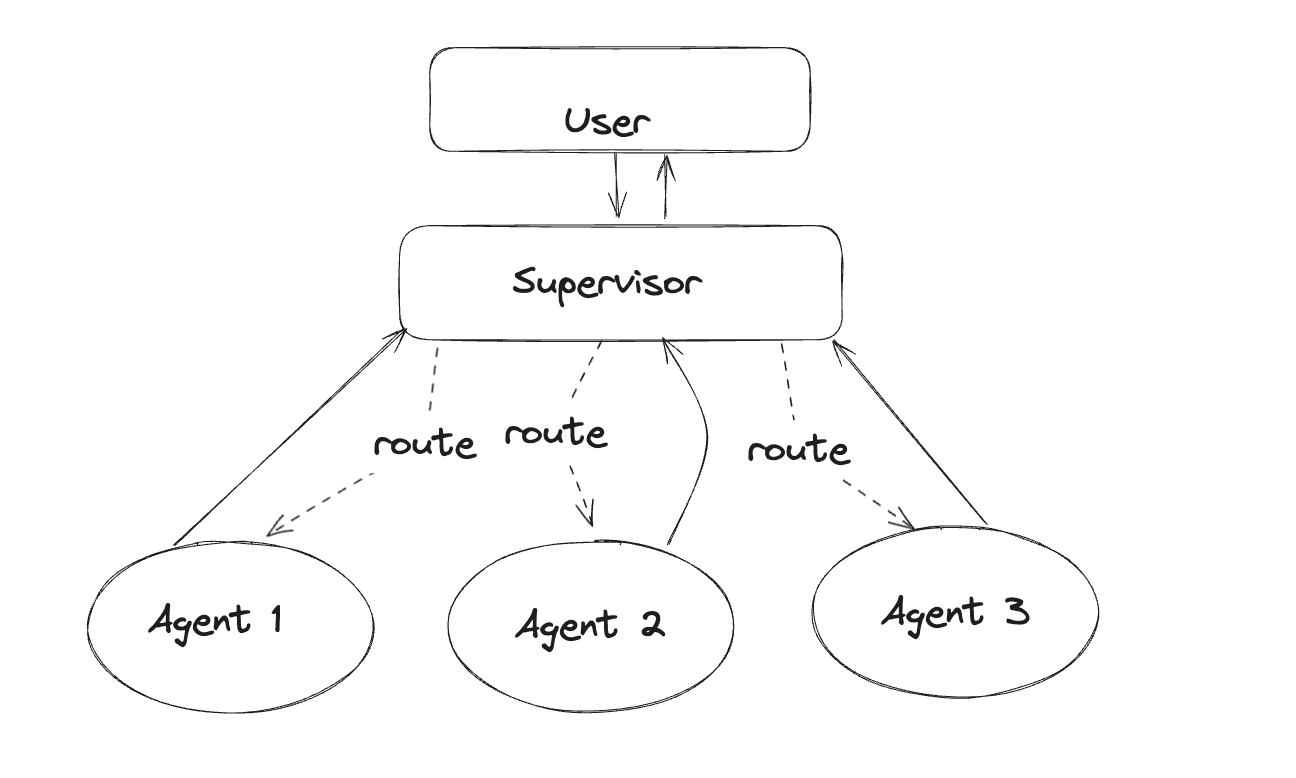

In [ ]:
var userHomeDir = System.getProperty("user.home");
var localRespoUrl = "file://" + userHomeDir + "/.m2/repository/";
var langchain4jVersion = "1.0.0-beta1";
var langgraph4jVersion = "1.4-SNAPSHOT";

In [ ]:
%%bash 
rm -rf \{userHomeDir}/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j

In [ ]:
%dependency /add-repo local \{localRespoUrl} release|never snapshot|always
// %dependency /list-repos
%dependency /add org.slf4j:slf4j-jdk14:2.0.9
%dependency /add org.bsc.langgraph4j:langgraph4j-core:\{langgraph4jVersion}
%dependency /add org.bsc.langgraph4j:langgraph4j-langchain4j:\{langgraph4jVersion}
%dependency /add dev.langchain4j:langchain4j:\{langchain4jVersion}
// %dependency /add dev.langchain4j:langchain4j-open-ai:\{langchain4jVersion}
%dependency /add dev.langchain4j:langchain4j-ollama:\{langchain4jVersion}
%dependency /add net.sourceforge.plantuml:plantuml-mit:1.2024.8

%dependency /resolve

**utility to render graph respresentation in PlantUML**

In [28]:
import net.sourceforge.plantuml.SourceStringReader;
import net.sourceforge.plantuml.FileFormatOption;
import net.sourceforge.plantuml.FileFormat;
import org.bsc.langgraph4j.GraphRepresentation;

void displayDiagram( GraphRepresentation representation ) throws IOException { 
    
    var reader = new SourceStringReader(representation.getContent());

    try(var imageOutStream = new java.io.ByteArrayOutputStream()) {

        var description = reader.outputImage( imageOutStream, 0, new FileFormatOption(FileFormat.PNG));

        var imageInStream = new java.io.ByteArrayInputStream(  imageOutStream.toByteArray() );

        var image = javax.imageio.ImageIO.read( imageInStream );

        display(  image );

    }
}

**Initialize Log**

In [29]:
var lm = java.util.logging.LogManager.getLogManager();
lm.checkAccess(); 
try( var file = new java.io.FileInputStream("./logging.properties")) {
    lm.readConfiguration( file );
}
var log = org.slf4j.LoggerFactory.getLogger("multi-agent-supervisor");

**Graph State**

In [30]:
import org.bsc.langgraph4j.prebuilt.MessagesState;
import dev.langchain4j.data.message.ChatMessage;
import java.util.Optional;

class State extends MessagesState<ChatMessage> {

    public Optional<String> next() {
        return this.value("next");
    }

    public State(Map<String, Object> initData) {
        super( initData  );
    }
}


**Create Serializer**

This is important for supporting persistent state across graph execution

In [31]:
import org.bsc.langgraph4j.langchain4j.serializer.std.ChatMesssageSerializer;
import org.bsc.langgraph4j.langchain4j.serializer.std.ToolExecutionRequestSerializer;
import org.bsc.langgraph4j.serializer.std.ObjectStreamStateSerializer;
import dev.langchain4j.agent.tool.ToolExecutionRequest;

class StateSerializer extends ObjectStreamStateSerializer<State> {

    public StateSerializer() {
        super(State::new);

        mapper().register(ToolExecutionRequest.class, new ToolExecutionRequestSerializer());
        mapper().register(ChatMessage.class, new ChatMesssageSerializer());
    }
}


## Create Supervisor Agent

⚠️ Since this is just a POC the tool is mocked ⚠️

In [32]:
import dev.langchain4j.agent.tool.P;
import dev.langchain4j.agent.tool.Tool;
import dev.langchain4j.model.output.structured.Description;
import dev.langchain4j.service.V;
import dev.langchain4j.service.SystemMessage;
import dev.langchain4j.service.AiServices;
import dev.langchain4j.data.message.AiMessage;
import dev.langchain4j.data.message.UserMessage;
import dev.langchain4j.model.chat.ChatLanguageModel;
import org.bsc.langgraph4j.action.AsyncNodeAction;
import java.util.concurrent.CompletableFuture;
import static java.lang.String.format;


class SupervisorAgent implements AsyncNodeAction<State> {


    static class Router {
        @Description("Worker to route to next. If no workers needed, route to FINISH.")
        String next;

        @Override
        public String toString() {
            return format( "Router[next: %s]",next);
        }
    }

    interface Service {
        @SystemMessage( """
                You are a supervisor tasked with managing a conversation between the following workers: {{members}}.
                Given the following user request, respond with the worker to act next.
                Each worker will perform a task and respond with their results and status.
                When finished, respond with FINISH.
                """)
        Router evaluate(@V("members") String members, @dev.langchain4j.service.UserMessage String userMessage);
    }

    final Service service;
    public final String[] members = {"researcher", "coder" };

    public SupervisorAgent(ChatLanguageModel model ) {

        service = AiServices.create( Service.class, model );
    }

    @Override
    public CompletableFuture<Map<String, Object>> apply(State state) {
        
        var message = state.lastMessage().orElseThrow();

        var text = switch( message.type() ) {
            case USER -> ((UserMessage)message).singleText();
            case AI -> ((AiMessage)message).text();
            default -> throw new IllegalStateException("unexpected message type: " + message.type() );
        };

        var m = String.join(",", members);
        
        var result = service.evaluate( m, text );
        
        return CompletableFuture.completedFuture(Map.of( "next", result.next ));
    }
}


## Create Researcher Agent

⚠️ Since this is just a POC the tool is mocked ⚠️

In [33]:
class ResearchAgent implements AsyncNodeAction<State> {
    static class Tools {

        @Tool("""
        Use this to perform a research over internet
        """)
        String search(@P("internet query") String query) {
            log.info( "search query: '{}'", query );
            return """
            the games will be in Italy at Cortina '2026
            """;
        }
    }

    interface Service {
        String search(@dev.langchain4j.service.UserMessage  String query);
    }

    final Service service;

    public ResearchAgent( ChatLanguageModel model ) {
        service = AiServices.builder( Service.class )
                        .chatLanguageModel(model)
                        .tools( new Tools() )
                        .build();
    }
    @Override
    public CompletableFuture<Map<String, Object>> apply(State state) {
        var message = state.lastMessage().orElseThrow();
        var text = switch( message.type() ) {
            case USER -> ((UserMessage)message).singleText();
            case AI -> ((AiMessage)message).text();
            default -> throw new IllegalStateException("unexpected message type: " + message.type() );
        };
        var result = service.search( text );
        return CompletableFuture.completedFuture(Map.of( "messages", AiMessage.from(result) ));

    }
}


## Create Coder Agent

⚠️ Since this is just a POC the tool is mocked ⚠️

In [34]:
class CoderAgent implements AsyncNodeAction<State> {
    static class Tools {

        @Tool("""
            Use this to execute java code and do math. If you want to see the output of a value,
            you should print it out with `System.out.println(...);`. This is visible to the user.""")
        String search(@P("coder request") String request) {
            log.info( "CoderTool request: '{}'", request );
            return """
            2
            """;
        }
    }

    interface Service {
        String evaluate(@dev.langchain4j.service.UserMessage String code);
    }

    final Service service;

    public CoderAgent( ChatLanguageModel model ) {
        service = AiServices.builder( Service.class )
                .chatLanguageModel(model)
                .tools( new Tools() )
                .build();
    }
    @Override
    public CompletableFuture<Map<String, Object>> apply(State state) {
        var message = state.lastMessage().orElseThrow();
        var text = switch( message.type() ) {
            case USER -> ((UserMessage)message).singleText();
            case AI -> ((AiMessage)message).text();
            default -> throw new IllegalStateException("unexpected message type: " + message.type() );
            };
        var result = service.evaluate( text );
        return CompletableFuture.completedFuture(Map.of( "messages", AiMessage.from(result) ));

    }
}


**Initialize OLLAMA Models**

In [35]:
import dev.langchain4j.model.ollama.OllamaChatModel;

final ChatLanguageModel model = OllamaChatModel.builder()
    .baseUrl( "http://localhost:11434" )
    .temperature(0.0)
    .logRequests(true)
    .logResponses(true)
    .format( "json" )
    .modelName("deepseek-r1:14b")
    .build();

final ChatLanguageModel modelWithTool = OllamaChatModel.builder()
    .baseUrl( "http://localhost:11434" )
    .temperature(0.0)
    .logRequests(true)
    .logResponses(true)
    .modelName("llama3.1:latest")
    .build();


## Define Graph


In [36]:
import org.bsc.langgraph4j.StateGraph;
import static org.bsc.langgraph4j.StateGraph.END;
import static org.bsc.langgraph4j.StateGraph.START;
import static org.bsc.langgraph4j.action.AsyncEdgeAction.edge_async;


var workflow = new StateGraph<>( State.SCHEMA, new StateSerializer() )
.addNode( "supervisor", new SupervisorAgent(model) )
.addNode( "coder", new CoderAgent(modelWithTool) )
.addNode( "researcher", new ResearchAgent(modelWithTool) )
.addEdge( START, "supervisor")
.addConditionalEdges( "supervisor",
        edge_async( state ->
            state.next().orElseThrow()
        ), Map.of(
                "FINISH", END,
                "coder", "coder",
                "researcher", "researcher"
        ))
.addEdge( "coder", "supervisor")
.addEdge( "researcher", "supervisor")
;



**Display StateGraph**

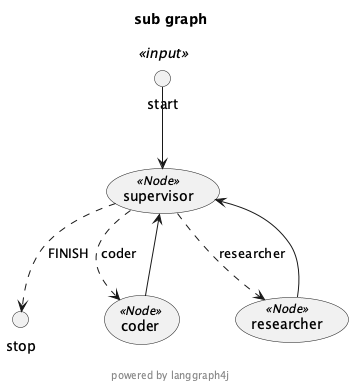

In [37]:
var representation = workflow.getGraph( GraphRepresentation.Type.PLANTUML, "sub graph", false );

displayDiagram( representation );

**Run Graph (Supervisor -> coder)** 

In [38]:
var graph = workflow.compile();

for( var event : graph.stream( Map.of( "messages", UserMessage.from("what are the result of 1 + 1 ?"))) ) {

    log.info( "{}", event );
}


START 
NodeOutput{node=__START__, state={messages=[UserMessage { name = null contents = [TextContent { text = "what are the result of 1 + 1 ?" }] }]}} 
CoderTool request: 'System.out.println(1+1);' 
NodeOutput{node=supervisor, state={next=coder, messages=[UserMessage { name = null contents = [TextContent { text = "what are the result of 1 + 1 ?" }] }]}} 
NodeOutput{node=coder, state={next=coder, messages=[UserMessage { name = null contents = [TextContent { text = "what are the result of 1 + 1 ?" }] }, AiMessage { text = "The result of 1 + 1 is 2." toolExecutionRequests = null }]}} 
NodeOutput{node=supervisor, state={next=FINISH, messages=[UserMessage { name = null contents = [TextContent { text = "what are the result of 1 + 1 ?" }] }, AiMessage { text = "The result of 1 + 1 is 2." toolExecutionRequests = null }]}} 
NodeOutput{node=__END__, state={next=FINISH, messages=[UserMessage { name = null contents = [TextContent { text = "what are the result of 1 + 1 ?" }] }, AiMessage { text = "

**Run Graph (Supervisor -> researcher)** 

In [39]:
var graph = workflow.compile();

for( var event : graph.stream( Map.of( "messages", UserMessage.from("where are next winter olympic games ?"))) ) {

    log.info( "{}", event );
}


START 
NodeOutput{node=__START__, state={messages=[UserMessage { name = null contents = [TextContent { text = "where are next winter olympic games ?" }] }]}} 
search query: 'next winter olympic games location' 
NodeOutput{node=supervisor, state={next=researcher, messages=[UserMessage { name = null contents = [TextContent { text = "where are next winter olympic games ?" }] }]}} 
NodeOutput{node=researcher, state={next=researcher, messages=[UserMessage { name = null contents = [TextContent { text = "where are next winter olympic games ?" }] }, AiMessage { text = "The next Winter Olympic Games will take place in Cortina d'Ampezzo, Italy in 2026." toolExecutionRequests = null }]}} 
NodeOutput{node=supervisor, state={next=FINISH, messages=[UserMessage { name = null contents = [TextContent { text = "where are next winter olympic games ?" }] }, AiMessage { text = "The next Winter Olympic Games will take place in Cortina d'Ampezzo, Italy in 2026." toolExecutionRequests = null }]}} 
NodeOutput{